In [20]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,balanced_accuracy_score,confusion_matrix, ConfusionMatrixDisplay,roc_auc_score,top_k_accuracy_score
from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV







In [2]:

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

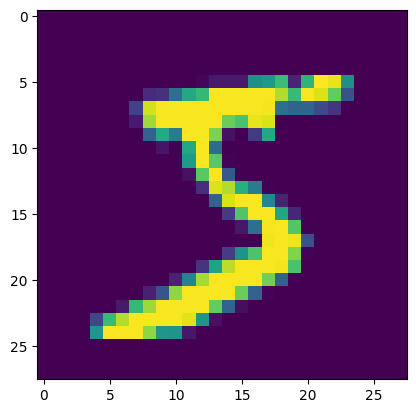

True Label: 5


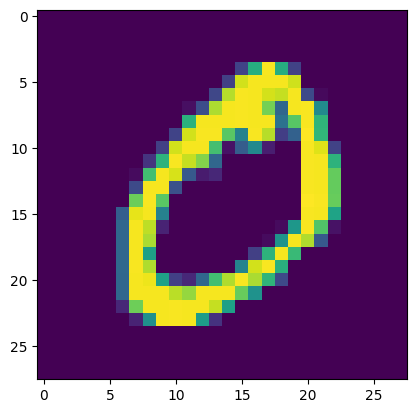

True Label: 0


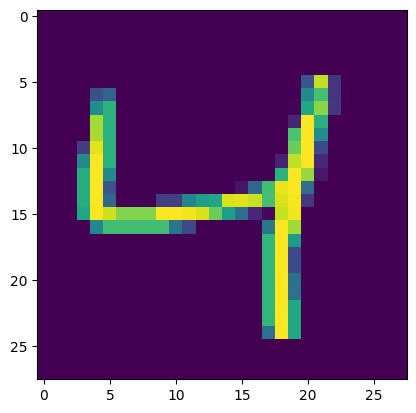

True Label: 4


In [3]:
# Plotting some sample data with their true labels
for i in range(3):
    plt.imshow(train_X[i])
    plt.show()
    print(f'True Label: {train_y[i]}')

In [4]:
#Checking For Null in Data
print(f"Number of NaN in Training Data: {np.isnan(train_X).sum()}")

print(f"Number of NaN in Test Data: {np.isnan(test_X).sum()}")

Number of NaN in Training Data: 0
Number of NaN in Test Data: 0


In [5]:
# Distribution of Classes in Training Data
unique, counts = np.unique(train_y, return_counts=True)
counts = np.round((counts / counts.sum())*100,2)
print(np.asarray((unique, counts)).T)

[[ 0.    9.87]
 [ 1.   11.24]
 [ 2.    9.93]
 [ 3.   10.22]
 [ 4.    9.74]
 [ 5.    9.04]
 [ 6.    9.86]
 [ 7.   10.44]
 [ 8.    9.75]
 [ 9.    9.92]]


In [6]:
# Distribution of Classes in Test Data
unique, counts = np.unique(test_y, return_counts=True)
counts = np.round((counts / counts.sum())*100,2)
print(np.asarray((unique, counts)).T)

[[ 0.    9.8 ]
 [ 1.   11.35]
 [ 2.   10.32]
 [ 3.   10.1 ]
 [ 4.    9.82]
 [ 5.    8.92]
 [ 6.    9.58]
 [ 7.   10.28]
 [ 8.    9.74]
 [ 9.   10.09]]


In [7]:
# Reshaping Data
X_train = train_X.reshape(train_X.shape[0],train_X.shape[1]*train_X.shape[2])
X_test = test_X.reshape(test_X.shape[0],test_X.shape[1]*test_X.shape[2])

In [8]:
# Removing all features with constant values
cols_with_const = pd.DataFrame(X_train).nunique(dropna=False) == 1
print(f"removing {cols_with_const.values.sum()} Columns with constant values")
X_train = X_train[:,~cols_with_const.values]
X_test = X_test[:,~cols_with_const.values]


removing 67 Columns with constant values


In [9]:
#Scaling the Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
#Performing PCA on Data to reduce dimensionality
pca = PCA()
pca.fit(X_train)


PCA()

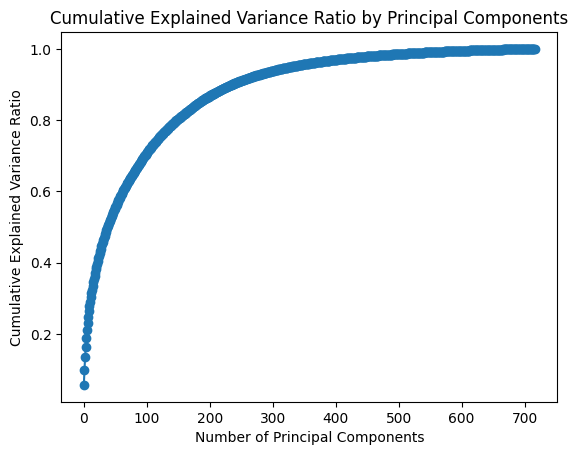

In [11]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio, marker='o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

In [12]:
pca_df = pd.DataFrame(pca.explained_variance_ratio_,columns=['value'])
pca_df = pca_df.sort_values(by='value',ascending=False)
pca_df['cum_value'] = pca_df['value'].cumsum()
pca_df = pca_df.reset_index(drop=True)
pca_df






,value,cum_value
0,5.646717e-02,0.056467
1,4.078272e-02,0.097250
2,3.739380e-02,0.134644
3,2.885115e-02,0.163495
4,2.521109e-02,0.188706
...,...,...
712,3.397958e-28,1.000000
713,6.500486e-32,1.000000
714,3.381853e-32,1.000000
715,4.580693e-33,1.000000


In [13]:
num_componets = pca_df[pca_df['cum_value'] > 0.95].index[0]
print(f'{(num_componets)} pca components required for greater than 95% explained variance')



330 pca components required for greater than 95% explained variance


In [14]:
#Refitting PCA with n_components = 330 and reducing dimensionality
pca = PCA(n_components=330)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape,X_test_pca.shape)

(60000, 330) (10000, 330)


# Building Model with PCA

LGBM Performance
The balanced accuracy is : 0.954


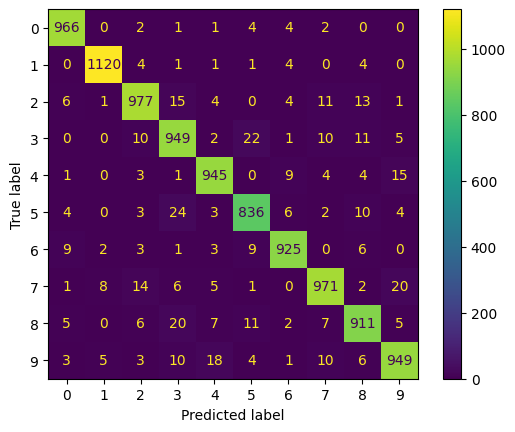

ROC AUC SCORE (One vs One ) : 0.998
 Top 2 Accuracy score : 0.984


In [15]:
# Fitting Gradient Boosted Trees
lgb_train = lgb.Dataset(X_train_pca, label=train_y,free_raw_data=False)
lgb_test = lgb.Dataset(X_test_pca, label=test_y,free_raw_data=False)

# specify your configurations as a dict
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_leaves": 100,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "num_class" :10,
}

model = lgb.train(params,
                  lgb_train)
print('LGBM Performance')

# Multi Class Classification Metrics
test_pred = model.predict(X_test_pca)
test_pred_acc = test_pred.argmax(axis=1)
print(f"The balanced accuracy is : {balanced_accuracy_score(test_y,test_pred_acc):.3f}")
labels = [i for i in range(10)]
cm = confusion_matrix(test_y, test_pred_acc, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

print(f"ROC AUC SCORE (One vs One ) : {roc_auc_score(test_y,test_pred,multi_class='ovo'):.3f}")
print(f" Top 2 Accuracy score : {top_k_accuracy_score(test_y, test_pred, k=2):.3f}")



Random Forest Performance
The balanced accuracy is : 0.939


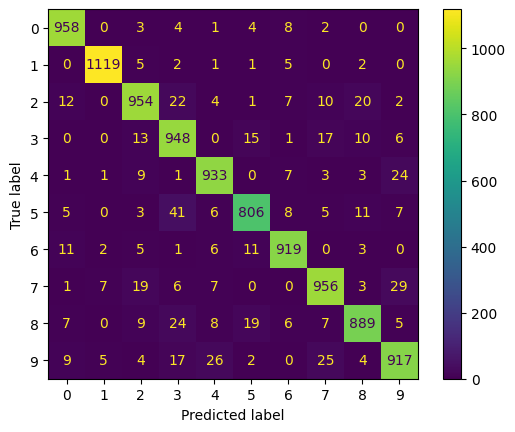

ROC AUC SCORE (One vs One ) : 0.996
 Top 2 Accuracy score : 0.980


In [16]:
# Fitting Random Forest
model = RandomForestClassifier(n_estimators=200,n_jobs=-1)
model.fit(X_train_pca,train_y)

print('Random Forest Performance')
# Multi Class Classification Metrics
test_pred = model.predict_proba(X_test_pca)
test_pred_acc = test_pred.argmax(axis=1)
print(f"The balanced accuracy is : {balanced_accuracy_score(test_y,test_pred_acc):.3f}")
labels = [i for i in range(10)]
cm = confusion_matrix(test_y, test_pred_acc, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

print(f"ROC AUC SCORE (One vs One ) : {roc_auc_score(test_y,test_pred,multi_class='ovo'):.3f}")
print(f" Top 2 Accuracy score : {top_k_accuracy_score(test_y, test_pred, k=2):.3f}")

# Building Model Without PCA

LGBM Performance
The balanced accuracy is : 0.975


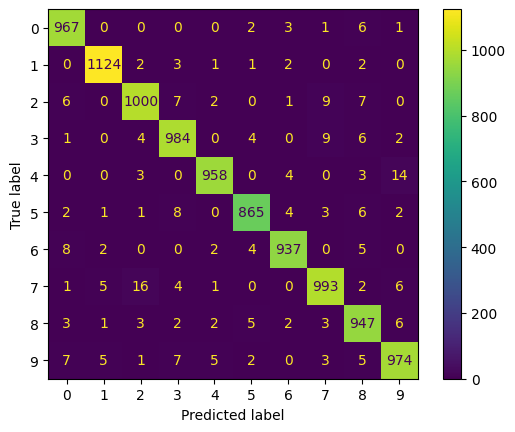

ROC AUC SCORE (One vs One ) : 1.000
 Top 2 Accuracy score : 0.992


In [17]:

# Fitting Gradient Boosted Trees
lgb_train = lgb.Dataset(X_train, label=train_y,free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=test_y,free_raw_data=False)

# specify your configurations as a dict
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_leaves": 100,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "num_class" :10,
}

model = lgb.train(params,
                  lgb_train)
print('LGBM Performance')
# Multi Class Classification Metrics
test_pred = model.predict(X_test)
test_pred_acc = test_pred.argmax(axis=1)
print(f"The balanced accuracy is : {balanced_accuracy_score(test_y,test_pred_acc):.3f}")
labels = [i for i in range(10)]
cm = confusion_matrix(test_y, test_pred_acc, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

print(f"ROC AUC SCORE (One vs One ) : {roc_auc_score(test_y,test_pred,multi_class='ovo'):.3f}")
print(f" Top 2 Accuracy score : {top_k_accuracy_score(test_y, test_pred, k=2):.3f}")

Random Forest Performance
The balanced accuracy is : 0.970


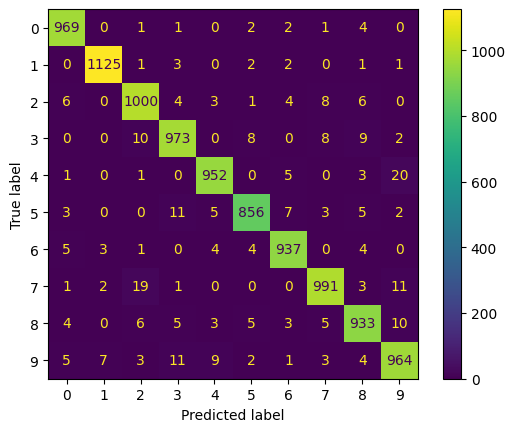

ROC AUC SCORE (One vs One ) : 0.999
 Top 2 Accuracy score : 0.991


In [18]:
# Fitting Random Forest
model = RandomForestClassifier(n_estimators=200,n_jobs=-1)
model.fit(X_train,train_y)

print('Random Forest Performance')
# Multi Class Classification Metrics
test_pred = model.predict_proba(X_test)
test_pred_acc = test_pred.argmax(axis=1)
print(f"The balanced accuracy is : {balanced_accuracy_score(test_y,test_pred_acc):.3f}")
labels = [i for i in range(10)]
cm = confusion_matrix(test_y, test_pred_acc, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

print(f"ROC AUC SCORE (One vs One ) : {roc_auc_score(test_y,test_pred,multi_class='ovo'):.3f}")
print(f" Top 2 Accuracy score : {top_k_accuracy_score(test_y, test_pred, k=2):.3f}")

In [28]:
# Choosing Best Hyperparamter for Random Forest Using RandomizedSearchCV

param_dist = {
    "n_estimators": list(range(1,201)),
    "max_depth" : list(range(1,15)),
    "min_samples_leaf": list(range(1,20))
}

model = RandomForestClassifier()

n_iter_search = 50
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=n_iter_search,n_jobs=-1,cv=3,verbose=1,scoring='balanced_accuracy'
)
random_search.fit(X_train,train_y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [25]:
cv_result_df = pd.DataFrame(random_search.cv_results_)
cv_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.207321,0.279532,0.384228,0.019603,62,17,10,"{'n_estimators': 62, 'min_samples_leaf': 17, '...",0.93550,0.93440,0.93855,0.936150,0.001755,2
1,1.547051,0.031655,0.086768,0.009342,13,16,1,"{'n_estimators': 13, 'min_samples_leaf': 16, '...",0.42190,0.44220,0.42485,0.429650,0.008956,20
2,14.527851,0.614380,0.479838,0.066986,89,15,8,"{'n_estimators': 89, 'min_samples_leaf': 15, '...",0.92085,0.91530,0.92545,0.920533,0.004150,7
3,0.606303,0.036309,0.039371,0.009222,3,16,5,"{'n_estimators': 3, 'min_samples_leaf': 16, 'm...",0.69155,0.71105,0.71305,0.705217,0.009698,14
4,1.373503,0.089158,0.078914,0.017664,45,5,1,"{'n_estimators': 45, 'min_samples_leaf': 5, 'm...",0.52825,0.50130,0.52580,0.518450,0.012168,18
5,2.358816,0.101855,0.121778,0.023833,79,10,1,"{'n_estimators': 79, 'min_samples_leaf': 10, '...",0.53700,0.51595,0.50615,0.519700,0.012871,17
6,8.379983,0.345561,0.323698,0.084381,48,8,9,"{'n_estimators': 48, 'min_samples_leaf': 8, 'm...",0.93165,0.92740,0.93120,0.930083,0.001906,3
7,17.548217,0.466384,0.638160,0.132411,100,9,8,"{'n_estimators': 100, 'min_samples_leaf': 9, '...",0.92400,0.91730,0.92705,0.922783,0.004072,5
8,10.461842,0.077202,0.458097,0.006147,89,2,5,"{'n_estimators': 89, 'min_samples_leaf': 2, 'm...",0.85100,0.84765,0.86095,0.853200,0.005648,9
9,4.972930,0.139213,0.249623,0.048212,24,3,9,"{'n_estimators': 24, 'min_samples_leaf': 3, 'm...",0.92650,0.92220,0.93060,0.926433,0.003430,4


In [26]:
#Best Parameters
random_search.best_params_

{'n_estimators': 77, 'min_samples_leaf': 10, 'max_depth': 10}

Random Forest Performance
The balanced accuracy is : 0.944


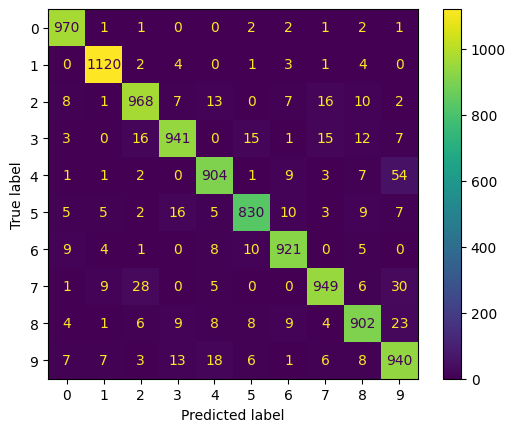

ROC AUC SCORE (One vs One ) : 0.997
 Top 2 Accuracy score : 0.981


In [27]:
#Fitting Random Forest with Best Parameters
model = RandomForestClassifier(**random_search.best_params_,n_jobs=-1)
model.fit(X_train,train_y)

print('Random Forest Performance')
# Multi Class Classification Metrics
test_pred = model.predict_proba(X_test)
test_pred_acc = test_pred.argmax(axis=1)
print(f"The balanced accuracy is : {balanced_accuracy_score(test_y,test_pred_acc):.3f}")
labels = [i for i in range(10)]
cm = confusion_matrix(test_y, test_pred_acc, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

print(f"ROC AUC SCORE (One vs One ) : {roc_auc_score(test_y,test_pred,multi_class='ovo'):.3f}")
print(f" Top 2 Accuracy score : {top_k_accuracy_score(test_y, test_pred, k=2):.3f}")